In [1]:
import rasterio as rio
import numpy as np
import os

# Cloud mask demo

## Raster IO functions

In [2]:
def read_img(img_path):
    with rio.open(img_path, 'r') as f:
        arr = f.read() # (bands, rows, columns)
    return arr

def get_img_profile(img_path):
    with rio.open(img_path, 'r') as f:
        return f.profile


def save_img_band(arr, out_path, dtype, profile):
    profile.update(
    dtype=dtype, #rio.uint8
    count=1,
    compress='lzw')

    with rio.open(out_path, 'w', **profile) as dst:
        dst.write(np.squeeze(arr).astype(dtype), 1)

## Description of the bits in the one-byte Quality Assessment layer

In [3]:
# Please look at the HLS user guide for more details. 
# https://lpdaac.usgs.gov/documents/1326/HLS_User_Guide_V2.pdf
QA_BIT = {'cirrus': 0,
'cloud': 1,
'adj_cloud': 2,
'cloud shadow':3,
'snowice':4,
'water':5,
'aerosol_l': 6,
'aerosol_h': 7
}

## Demo of QA value to cloud mask

In [5]:
def test_mask(value, mask_list=['cloud', 'adj_cloud', 'cloud shadow', 'snowice', 'water', 'aerosol_high']):
    # This function takes a QA value and exports the desired mask value. 
    # The mask_list assigns the QA conditions you would like to mask.
    msk = 0
    for m in mask_list:
        if m in QA_BIT.keys():
            msk += (value & 1 << QA_BIT[m]) > 0
        if m == 'aerosol_high':
            msk += ((value & (1 << QA_BIT['aerosol_h'])) > 0) * ((value & (1 << QA_BIT['aerosol_l'])) > 0)
        if m == 'aerosol_moderate':
            msk += ((value & (1 << QA_BIT['aerosol_h'])) > 0) * ((value | (1 << QA_BIT['aerosol_l'])) != value)
        if m == 'aerosol_low':
            msk += ((value | (1 << QA_BIT['aerosol_h'])) != value) * ((value & (1 << QA_BIT['aerosol_l'])) > 0)
    return msk > 0

test_vals = [64, 66, 68, 70, 72, 80, 84, 96, 100, 112, 128, 130, 132, 134, 136, 138, 140, 144, 148, 160, 164, 176, 192, 194, 196, 198, 200, 202, 204, 206, 208, 212, 224, 228, 240, 244]
for val in test_vals:
    print('QA value and binary code:\t', val, '\t', "{0:08b}".format(val), 'Mask:\t', test_mask(val))


QA value and binary code:	 64 	 01000000 Mask:	 False
QA value and binary code:	 66 	 01000010 Mask:	 True
QA value and binary code:	 68 	 01000100 Mask:	 True
QA value and binary code:	 70 	 01000110 Mask:	 True
QA value and binary code:	 72 	 01001000 Mask:	 True
QA value and binary code:	 80 	 01010000 Mask:	 True
QA value and binary code:	 84 	 01010100 Mask:	 True
QA value and binary code:	 96 	 01100000 Mask:	 True
QA value and binary code:	 100 	 01100100 Mask:	 True
QA value and binary code:	 112 	 01110000 Mask:	 True
QA value and binary code:	 128 	 10000000 Mask:	 False
QA value and binary code:	 130 	 10000010 Mask:	 True
QA value and binary code:	 132 	 10000100 Mask:	 True
QA value and binary code:	 134 	 10000110 Mask:	 True
QA value and binary code:	 136 	 10001000 Mask:	 True
QA value and binary code:	 138 	 10001010 Mask:	 True
QA value and binary code:	 140 	 10001100 Mask:	 True
QA value and binary code:	 144 	 10010000 Mask:	 True
QA value and binary code:	 148 	 1

## HLS cloud mask function

In [6]:
def hls_mask(mask_img_path, mask_list=['cloud', 'adj_cloud', 'cloud shadow', 'snowice', 'water', 'aerosol_high']):
    # This function takes the HLS Fmask layer as input and exports the desired mask image array. 
    # The mask_list assigns the QA conditions you would like to mask.
    # The default mask_list setting is coded for a vegetation application, so it also removes water and snow/ice.
    arr = read_img(mask_img_path)
    msk = np.zeros_like(arr)
    for m in mask_list:
        if m in QA_BIT.keys():
            msk += (arr & 1 << QA_BIT[m]) > 0
        if m == 'aerosol_high':
            msk += ((arr & (1 << QA_BIT['aerosol_h'])) > 0) * ((arr & (1 << QA_BIT['aerosol_l'])) > 0)
        if m == 'aerosol_moderate':
            msk += ((arr & (1 << QA_BIT['aerosol_h'])) > 0) * ((arr | (1 << QA_BIT['aerosol_l'])) != arr)
        if m == 'aerosol_low':
            msk += ((arr | (1 << QA_BIT['aerosol_h'])) != arr) * ((arr & (1 << QA_BIT['aerosol_l'])) > 0)
    return msk > 0

## Demo of HLS QA map to cloud  map

Raw QA layer


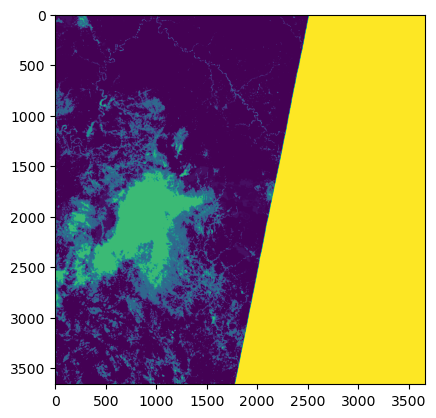

Cloud mask


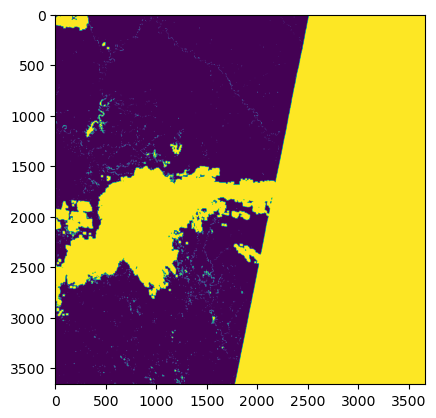

In [7]:
from matplotlib import pyplot
fmask_img = r'C:\Users\qzhou2\C_workdir\HLSdownload\HLS.L30.T12RZP.2021147T174059.v2.0.Fmask.tif'

src = rio.open(fmask_img)
print('Raw QA layer')
pyplot.imshow(src.read(1))
pyplot.show()

arr_mask = hls_mask(fmask_img)
out_path = os.path.join(os.path.dirname(fmask_img), 'cloud_mask.tif')
save_img_band(arr_mask, out_path, rio.uint8, get_img_profile(fmask_img))
src = rio.open(out_path)
print('Cloud mask')
pyplot.imshow(src.read(1))
pyplot.show()

Raw QA layer


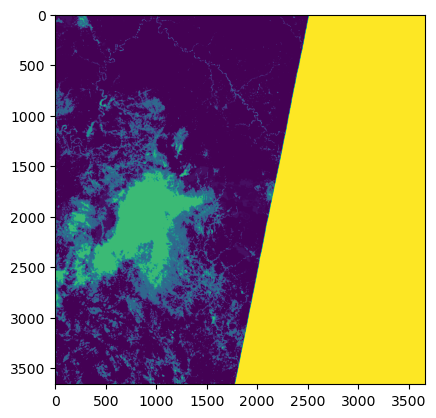

[[64 64 64 ... -- -- --]
 [64 64 64 ... -- -- --]
 [64 64 64 ... -- -- --]
 ...
 [64 64 64 ... -- -- --]
 [64 64 64 ... -- -- --]
 [64 64 64 ... -- -- --]]
Cloud mask


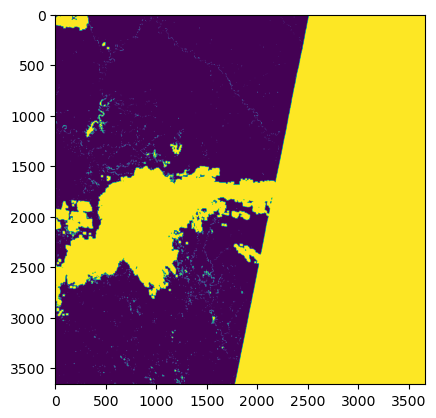

In [8]:
def hls_mask_ma(ma_arr, mask_list=['cloud', 'adj_cloud', 'cloud shadow', 'snowice', 'water', 'aerosol_high']):
    # This function takes the masked QA array as input and exports the union mask image array. 
    # The mask_list assigns the QA conditions you would like to mask.
    # The default mask_list setting is coded for a vegetation application, so it also removes water and snow/ice.
    # Please make sure the ma_arr is integer data type as the "bitwise_and" only works for integer and bool.
    arr = ma_arr.data
    msk = np.zeros_like(arr)#.astype(np.bool)
    for m in mask_list:
        if m in QA_BIT.keys():
            msk += (arr & 1 << QA_BIT[m]) > 0
        if m == 'aerosol_high':
            msk += ((arr & (1 << QA_BIT['aerosol_h'])) > 0) * ((arr & (1 << QA_BIT['aerosol_l'])) > 0)
        if m == 'aerosol_moderate':
            msk += ((arr & (1 << QA_BIT['aerosol_h'])) > 0) * ((arr | (1 << QA_BIT['aerosol_l'])) != arr)
        if m == 'aerosol_low':
            msk += ((arr | (1 << QA_BIT['aerosol_h'])) != arr) * ((arr & (1 << QA_BIT['aerosol_l'])) > 0)
    ma_arr.mask += msk > 0
    return ma_arr

from matplotlib import pyplot
fmask_img = r'C:\Users\qzhou2\C_workdir\HLSdownload\HLS.L30.T12RZP.2021147T174059.v2.0.Fmask.tif'

src = rio.open(fmask_img)
print('Raw QA layer')
pyplot.imshow(src.read(1))
pyplot.show()

ma_arr = np.ma.masked_array(src.read(1), mask=np.zeros_like(src.read(1)))
arr_mask = hls_mask_ma(ma_arr)
print(ma_arr)
out_path = os.path.join(os.path.dirname(fmask_img), 'cloud_mask_ma2.tif')
save_img_band(arr_mask.mask, out_path, rio.uint8, get_img_profile(fmask_img))
with rio.open(out_path) as src:
    print('Cloud mask')
    pyplot.imshow(src.read(1))
    pyplot.show()